<a href="https://colab.research.google.com/github/compi1234/spchlab/blob/main/lab09_hmm2/ex_hmm2_deltas_notebook.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Google Colab" title="Open in Google Colab"></a>

# EX-HMM2



#### SETUP
Build a HMM speech recognizer that can distinguish between the two words ME and YOU.  
- The models of each consist of two states (assumed to represent the underlying phonemes).
- You have one-dimensional continuous observations and will model these with Gaussian distributions.
- You have a small database of example recordings with three example utterances for each word, and corresponding manual phonetic segmentations

The data for ME:
> X = \[4.0 2.5 1.0 2.0 5.0 8.0 \],  S = \[1 1 1 2 2 2\]   
> X = \[4.5 2.0 1.0 1.5 6.5 7.0\],   S = \[1 1 1 2 2 2\]   
> X = \[3.5 2.5 1.5 3.0 7.0\],       S = \[1 1 1 2 2\]   

The data for YOU:
> X= \[1.0 2.0 4.5 8.0 6.5 1.5\] ,   S = \[1 1 1 2 2 2 \]   
> X= \[1.5 2.5 4.0 7.0 3.0 \],       S = \[ 1 1 1 2 2 \]   
> X= \[1.0 2.5 3.5 7.0 5.0 2.0\],    S = \[ 1 1 1 2 2 2 \]   

#### INSTRUCTIONS
The exercises in this notebook require a significant amount of computation.
- Preferably perform each TYPE of computation at least once by HAND
- Rely on the notebook code to verify what you did by HAND and fill in the other computations


In [ ]:
!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab,
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

  Cloning https://github.com/compi1234/pyspch.git to /tmp/pip-req-build-hzolipfo
  Running command git clone --filter=blob:none --quiet https://github.com/compi1234/pyspch.git /tmp/pip-req-build-hzolipfo
  Resolved https://github.com/compi1234/pyspch.git to commit 4a7892894fadda9d1d7dabf9bd4305352bd26a18
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.8 MB/s eta 0:00:00
  Created wheel for pyspch: filename=pyspch-0.8.3-py3-none-any.whl size=13931024 sha256=ba4e012f0663dbc19e497c8dd7cc72e8a3bf276082ca3ff34a9afbec2c19e57e
  Stored in directory: /tmp/pip-ephem-wheel-cache-jp836xqp/wheels/7a/a3/e6/c203dcb3c4447f7380a612758b80685a0444509b9b89f117f7
Successfully built pyspch


In [ ]:
# do all the imports
%matplotlib inline

import sys, os
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import copy
from sklearn import preprocessing

import pyspch.stats.probdist as Densities
from pyspch.stats import libhmm
import pyspch as Spch

# graphical and print preferences
ldesign = 50
cmap = sns.light_palette("caramel",ldesign,input="xkcd")
cmap20 = cmap[0:20]
cmap="OrRd_r"
pd.reset_option('display.float_format')
pd.set_option('display.precision',3)
mpl.rcParams['figure.figsize'] = [12.0, 6.0]
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlepad'] = 15
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.linewidth'] = 2
mpl.rc('lines', linewidth=3, color='k')

We define class **hmm_x** which is a super class of the **libhmm.hmm** class.   
We do this to highlight the implementation of 3 methods used in this notebook
with minimal code, but adapted to the problems handled here.
- training routine .fit()
- recognition routine .recognize()
- scoring routine .predict_proba()

In [ ]:
class hmm_x(libhmm.HMM):

    def fit(self,X,y):
        '''
        fit() takes a sequence of observations X together with their state (index) alignments y
        '''
        # training of the observation probabilities
        self.obs_model.fit(np.concatenate(X),np.concatenate(y))

        # train initial and transition probabilities
        init_counts = np.zeros(self.n_states,dtype='float')
        trans_counts = np.zeros((self.n_states,self.n_states),dtype='float')
        for (Xi,yi) in zip(X,y):
            init_counts[yi[0]] += 1.
            for j in range(1,Xi.shape[0]):
                trans_counts[ yi[j-1],yi[j] ] += 1.
        self.transmat = trans_counts / np.sum(trans_counts,axis=1)[:,np.newaxis]
        self.initmat = init_counts / np.sum(init_counts)
        if self.prob_style == "log":
            self.transmat = Spch.logf(self.transmat)
            self.initmat = Spch.logf(self.initmat)

    def align(self,X=None,method='Viterbi',end_states=None):
        '''
        Viterbi alignment for the current HMM model and observation sequence X
        This method allows to list allowed end_states, default is last state defined in the model
        '''
        trellis = libhmm.Trellis(self)
        trellis.viterbi_pass(X)
        seq_prob,end_state = trellis._finalize(end_states=end_states)
        return  trellis.backtrace(end_state=end_state)

    # find the HMM likelihood score for input sequences for the best admissible end_states
    def predict_proba(self,X=None,method='Viterbi',end_states=None):
        results = np.array([])
        for Xi in X:
            trellis = libhmm.Trellis(self)
            if method == "Viterbi":
                trellis.viterbi_pass(Xi)
            else:
                trellis.forward_pass(Xi)
            seq_prob,_ = trellis._finalize(end_states=end_states)
            results = np.append(results,seq_prob)
        return results

    # find the HMM likelihood score for input sequences for all admissible end_states
    def recognize(self,X=None,method='Viterbi',end_states=None,Print=True):
        if end_states is None: end_states = self.end_states
        results = []
        for Xi in X:
            results_i = []
            trellis = libhmm.Trellis(self)
            if method == "Viterbi":
                trellis.viterbi_pass(Xi)
            else:
                trellis.forward_pass(Xi)
            for end_state in end_states:
                seq_prob,_ = trellis._finalize(end_states=[end_state])
                results_i.append((end_state,seq_prob))
            results.append(results_i)
        if(Print):
            for i in range(len(results)):
                print("\n== Sample (%d) === " %i)
                for res in results[i]:
                    (end_s,score) = res
                    print('Endstate=%s, score=%.2e' % (self.states[end_s],score) )
        return results

In [ ]:
# CODE BLOCK FOR FEATURE TRANSFORMATION and AUGMENTATION
#
# padding copies the edge frames N times
# e.g.   padding sequence [a,b,c,d] with 2 frames will result in
#                     [a,a,a,b,c,d,d,d]
def pad_time(X,N = 1):
    X_padded = np.pad(X,[(N,N),(0,0)],mode='edge')
    return X_padded

# deltas are computed as first order difference:
# delta_x(t) = x(t+1) - x(t-1) ; the input sequence is padded at the edges
def deltas(X):
    X_p = pad_time(X,N=1)
    delta_X = X_p[2:,:] - X_p[0:-2,:]
    return delta_X

# splice 2*N+1 frames , i.e. add Ns frames on left and right side
# to the current feature vector and stack everything in a high dimensional supervector
def splice(X,N=1):
    X_p = pad_time(X,N=N)
    X_s = X
    T = X.shape[0]
    for i in range(1,N+1):
        X_s = np.concatenate( (X_p[N-i:N-i+T,:],X_s,X_p[N+i:N+i+T,:]), axis=1)
    return X_s

# merges two feature streams into one
def merge(Xarray):
    X_m = np.concatenate(Xarray,axis=1)
    return X_m

# utility to compute variants of augmented features
def compute_augmented_features(X):
    X_delta = []
    X_aug=[]
    X_seg=[]
    for Xi in X:
        Xid = deltas(Xi)
        X_delta.append(Xid)
        X_aug.append( merge((Xi,Xid)) )
        X_seg.append( splice(Xi,N=1) )
    return X_delta, X_aug, X_seg

## Data Encoding

In [ ]:
# CODE BLOCK FOR GENERATING THE DATA
# first define the phone set and make a hashing index to map labels to index
phones_ME = np.array(["M","IY"])
phones_YOU = np.array(["Y","UW"])
ph2indx_ME = dict( zip(phones_ME, range(0,len(phones_ME))) )
ph2indx_YOU = dict( zip(phones_YOU, range(0,len(phones_YOU))) )

#
# Example Data for "me" and "you"
#
X_ME = [
 np.array([4.0,2.5,1.0,2.0,5.0,8.0]).reshape(-1,1),
 np.array([4.5,2.0,1.0,1.5,6.5,7.0]).reshape(-1,1),
 np.array([3.5,2.5,1.5,3.0,7.0]).reshape(-1,1)
]
X_ME_concatenated = np.concatenate(X_ME)

ph_ME = [
    np.array(["M","M","M","IY","IY","IY"]),
    np.array(["M","M","M","IY","IY","IY"]),
    np.array(["M","M","M","IY","IY"])
]

X_YOU = [
 np.array([1.0,2.0,4.5,8.0,6.5,1.5]).reshape(-1,1),
 np.array([1.5,2.5,4.0,7.0,3.0]).reshape(-1,1),
 np.array([1.0,2.5,3.5,7.0,5.0,2.0]).reshape(-1,1)
]
X_YOU_concatenated = np.concatenate(X_YOU)

ph_YOU = [
 np.array([ "Y","Y","Y","UW","UW","UW"]),
 np.array([ "Y","Y","Y","UW","UW"]),
 np.array([ "Y","Y","Y","UW","UW","UW"])
]

# training indices for all alignments
y_ME = [ np.array( [ ph2indx_ME[x] for x in ph ]) for ph in ph_ME ]
y_ME_concatenated = np.concatenate(y_ME)

y_YOU = [ np.array( [ ph2indx_YOU[x] for x in ph ]) for ph in ph_YOU ]
y_YOU_concatenated = np.concatenate(y_YOU)



## Observation models

In [ ]:
Gauss_ME = Densities.Gaussian()
Gauss_ME.fit(X_ME_concatenated,y_ME_concatenated)
Gauss_ME.print_model(precision=3)

,prior,mean,var
0,0.529,[2.5],[1.4444444493838908]
1,0.471,[5.0],[5.562500004939446]


### Model of YOU

In [ ]:
Gauss_YOU = Densities.Gaussian()
Gauss_YOU.fit(X_YOU_concatenated,y_YOU_concatenated)
Gauss_YOU.print_model(precision=3)

,prior,mean,var
0,0.529,[2.5],[1.4444444493838908]
1,0.471,[5.0],[5.562500004939446]


## Trained Model

Means and variances can be computed from all the frames with the same label

### Model for ME

In [ ]:
hmm_ME = hmm_x(obs_model=Gauss_ME, states=np.array(["M","IY"]), end_states=[1])
hmm_ME.set_probstyle("log")
hmm_ME.fit(X_ME,y_ME)
hmm_ME.print_model()


HMM STATE MODEL



,M,IY
Pinit(.),0.0,-100.0


,M,IY
P(M|.),-0.405,-100.0
P(IY|.),-1.099,0.0



OBSERVATION MODEL



,prior,mean,var
0,0.529,[2.5],[1.4444444493838908]
1,0.471,[5.0],[5.562500004939446]


### Model for YOU

In [ ]:
hmm_YOU = hmm_x(obs_model=Gauss_YOU, states=np.array(["Y","UW"]), end_states=[1])
hmm_YOU.set_probstyle("log")
hmm_YOU.fit(X_YOU, y_YOU)
hmm_YOU.print_model()


HMM STATE MODEL



,Y,UW
Pinit(.),0.0,-100.0


,Y,UW
P(Y|.),-0.405,-100.0
P(UW|.),-1.099,0.0



OBSERVATION MODEL



,prior,mean,var
0,0.529,[2.5],[1.4444444493838908]
1,0.471,[5.0],[5.562500004939446]


## Viterbi on New Utterance

### Alignment with Model of ME

To obtain the observation probabilities, we have to use the likelihood function (GMM with one component):

$$
p(x|\mu,\sigma)=\frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}
$$

Remember that we do everything with log probabilities.

In [ ]:
## test utterances
X_test = [np.array([1.2, 3.1, 4.8, 7.6, 4.3]).reshape(-1,1)]
tr_ME = libhmm.Trellis(hmm_ME)
tr_ME.viterbi_pass(X_test[0])
tr_ME.print_trellis()


Observation Probabilities



,0,1,2,3,4
M,-1.688,-1.227,-2.934,-10.106,-2.224
IY,-3.075,-2.101,-1.781,-2.385,-1.821



Trellis Probabilities (Viterbi)



,0,1,2,3,4
M,-1.688,-3.321,-6.66,-17.172,-19.802
IY,-103.075,-4.888,-6.20,-8.584,-10.405



Alignment



,0,1,2,3,4
VIT-ALIGN,M,M,IY,IY,IY



Sequence Probability: -1.04e+01



### Alignment with Model of YOU

In [ ]:
## test utterances
X_test = [np.array([1.2, 3.1, 4.8, 7.6, 4.3]).reshape(-1,1)]
tr_YOU = libhmm.Trellis(hmm_YOU)
tr_YOU.viterbi_pass(X_test[0])
tr_YOU.print_trellis()


Observation Probabilities



,0,1,2,3,4
Y,-1.688,-1.227,-2.934,-10.106,-2.224
UW,-3.075,-2.101,-1.781,-2.385,-1.821



Trellis Probabilities (Viterbi)



,0,1,2,3,4
Y,-1.688,-3.321,-6.66,-17.172,-19.802
UW,-103.075,-4.888,-6.20,-8.584,-10.405



Alignment



,0,1,2,3,4
VIT-ALIGN,Y,Y,UW,UW,UW



Sequence Probability: -1.04e+01



### Feature Plots

The figures show training examples of both words vs. the test observation.

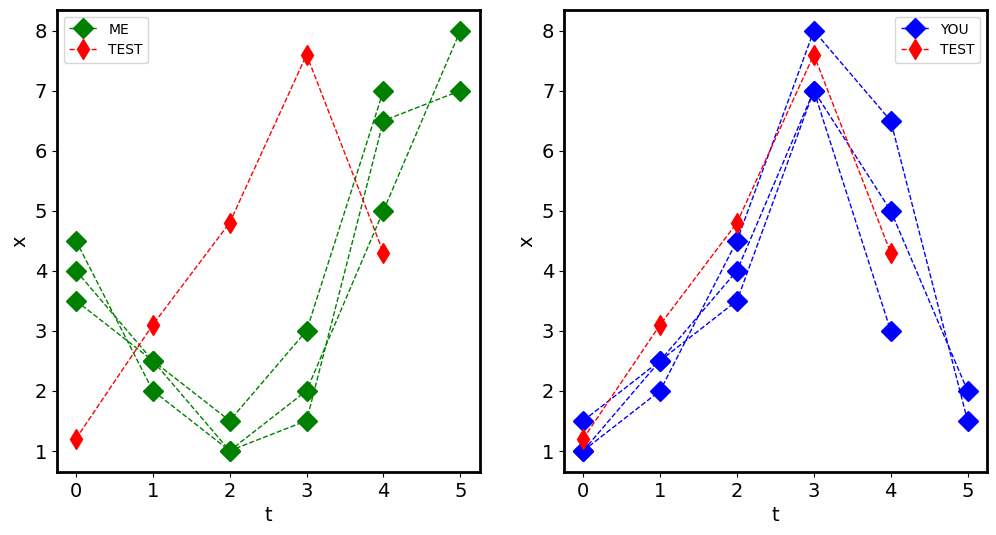

In [ ]:
fig,ax = plt.subplots(1,2)
kw1=dict(ls='--',lw=1,ms=10)
kw2=dict(fontsize=14)
words = ['ME','YOU']
data = [X_ME,X_YOU]
fmts = ['gD','bD']
for k in (0,1):
    for X in data[k]:
        lx, = ax[k].plot(X,fmts[k],**kw1,label=words[k])
    lt, = ax[k].plot(X_test[0],'rd',**kw1,label='TEST')
    ax[k].legend(handles=[lx,lt])
    ax[k].set_xlabel("t",**kw2)
    ax[k].set_ylabel("x",**kw2)

## TASK 2

###  Feature Transformations : Delta's, Segmental Features, ...
The feature transformations we use here have the sole intention to put emphasis on local in time trends in the data that may not be captured by a naive HMM.   
In all cases we construct a new feature vector that has a wider look on the data.  
There are principally 2 possibilities to achieve this:
- using segmental input by splicing a number of frames together
    + this keeps all original segmental information together
    + but has as negative side effect that information gets strongly correlated
- using delta features
    + here we augment the feature vector with the derivatives over time
    + this has as great advantage that the augmented features are quite decorrelated from the original feature vector
    
For each of these operations we need to take special care about the edges , i.e. start and end of our sequence data.   The standard procedure is to pad the original sequence on the left and right with the required number of frames to make a transformed sequence of equal length that can still be aligned with the original label sequence.  Assuming that frames are more or less stationary locally in time, it makes sense to extend the sequence data with copies of the edge values.

In [ ]:
# now compute
## a. delta features
## b. augmented features comprising original+deltas
## c. segmental features comprising 3 frames of data (same data span as deltas)
#
X_delta_ME, _, _ = compute_augmented_features(X_ME)
X_delta_YOU, _, _ = compute_augmented_features(X_YOU)

X_test_delta, _, _ = compute_augmented_features(X_test)
# X_delta, X_test_delta
#print("Delta Features (training): ",X_delta)

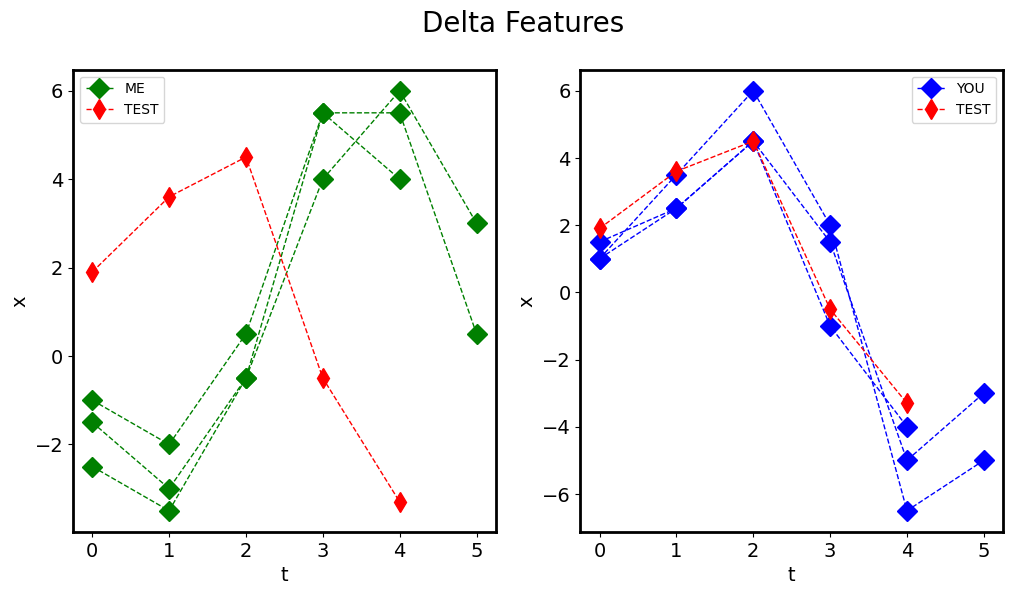

In [ ]:
fig,ax = plt.subplots(1,2)
kw1=dict(ls='--',lw=1,ms=10)
kw2=dict(fontsize=14)
words = ['ME','YOU']
data = [X_delta_ME,X_delta_YOU]
fmts = ['gD','bD']
for k in (0,1):
    for X in data[k]:
        lx, = ax[k].plot(X,fmts[k],**kw1,label=words[k])
    lt, = ax[k].plot(X_test_delta[0],'rd',**kw1,label='TEST')
    ax[k].legend(handles=[lx,lt])
    ax[k].set_xlabel("t",**kw2)
    ax[k].set_ylabel("x",**kw2)
fig.suptitle("Delta Features",fontsize=20);

## Train new models with delta features

### Delta Model for ME

In [ ]:
#
print("++++++++ MODEL WITH DELTA's ONLY ++++++++")
hmm_ME_delta = copy.deepcopy(hmm_ME)
hmm_ME_delta.fit(X_delta_ME,y_ME)
hmm_ME_delta.print_model()
#
print("++++++++ AUGMENTED MODEL WITH DELTA's ++++++++")
hmm_YOU_delta = copy.deepcopy(hmm_YOU)
hmm_YOU_delta.fit(X_delta_YOU,y_YOU)
hmm_YOU_delta.print_model()
#

++++++++ MODEL WITH DELTA's ONLY ++++++++

HMM STATE MODEL



,M,IY
Pinit(.),0.0,-100.0


,M,IY
P(M|.),-0.405,-100.0
P(IY|.),-1.099,0.0



OBSERVATION MODEL



,prior,mean,var
0,0.529,[-1.5555555555555556],[1.5246913686111965]
1,0.471,[4.25],[2.937500010586505]


++++++++ AUGMENTED MODEL WITH DELTA's ++++++++

HMM STATE MODEL



,Y,UW
Pinit(.),0.0,-100.0


,Y,UW
P(Y|.),-0.405,-100.0
P(UW|.),-1.099,0.0



OBSERVATION MODEL



,prior,mean,var
0,0.529,[3.0],[2.7222222356270667]
1,0.471,[-2.625],[8.671875013404843]


### Recognize with the different Models



In [ ]:
tr_ME_delta = libhmm.Trellis(hmm_ME_delta)
tr_ME_delta.viterbi_pass(X_test_delta[0])
tr_ME_delta.print_trellis()

tr_YOU_delta = libhmm.Trellis(hmm_YOU_delta)
tr_YOU_delta.viterbi_pass(X_test_delta[0])
tr_YOU_delta.print_trellis()


Observation Probabilities



,0,1,2,3,4
M,-5.046,-9.846,-13.155,-1.495,-2.128
IY,-2.398,-1.530,-1.468,-5.298,-11.160



Trellis Probabilities (Viterbi)



,0,1,2,3,4
M,-5.046,-15.297,-28.858,-30.759,-33.292
IY,-102.398,-7.674,-9.142,-14.440,-25.601



Alignment



,0,1,2,3,4
VIT-ALIGN,M,IY,IY,IY,IY



Sequence Probability: -2.56e+01


Observation Probabilities



,0,1,2,3,4
Y,-1.642,-1.486,-1.833,-3.670,-8.710
UW,-3.180,-4.233,-4.926,-2.259,-2.025



Trellis Probabilities (Viterbi)



,0,1,2,3,4
Y,-1.642,-3.533,-5.772,-9.847,-18.962
UW,-103.180,-6.974,-9.558,-9.130,-11.155



Alignment



,0,1,2,3,4
VIT-ALIGN,Y,Y,Y,UW,UW



Sequence Probability: -1.12e+01

